In [1]:
#load images
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks
import matplotlib.pyplot as plt 
from PIL import Image
import os
%matplotlib inline

2023-08-29 14:14:17.677277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 14:14:17.783428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-29 14:14:17.783447: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-29 14:14:17.805896: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-29 14:14:18.587983: W tensorflow/stream_executor/platform/de

### Load images

In [3]:
batch_size = 16
train_data_dir = "raw_data/training-data-binary/"
#test_data_dir = "raw_data/test-data-binary/"

train_ds = image_dataset_from_directory(
  train_data_dir,
  labels = "inferred",
  label_mode = "binary",
  #class_names = ['clean','dust'],  
  seed=123,
  image_size=(225, 225),
  batch_size=batch_size,
  validation_split=0.2,
  subset='both'
) 

train_data = train_ds[0]
val_data = train_ds[1]

Found 227 files belonging to 2 classes.
Using 182 files for training.
Using 45 files for validation.


### Binary model: Clean vs Snow

In [4]:
# We'll use a model with the same convolutional layers, but we'll add Augmentation layers before that

model_clean_snow = Sequential()

model_clean_snow.add(layers.Rescaling(1./255, input_shape = (225, 225, 3)))

# Data Augmentation Layers

model_clean_snow.add(layers.RandomFlip("horizontal"))
model_clean_snow.add(layers.RandomZoom(0.1))
model_clean_snow.add(layers.RandomTranslation(0.2, 0.2))
model_clean_snow.add(layers.RandomRotation(0.1))


# Convolutional Layers

model_clean_snow.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same"))
model_clean_snow.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


model_clean_snow.add(layers.Conv2D(filters = 32, kernel_size = (3,3), input_shape = (225, 225, 3), activation="relu", padding = "same"))
model_clean_snow.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


model_clean_snow.add(layers.Conv2D(filters = 64, kernel_size = (3,3), input_shape = (225, 225, 3), activation="relu", padding = "same"))
model_clean_snow.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

model_clean_snow.add(layers.Conv2D(filters = 128, kernel_size = (3,3), input_shape = (225, 225, 3), activation="relu", padding = "same"))
model_clean_snow.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

model_clean_snow.add(layers.Flatten())

model_clean_snow.add(layers.Dense(64, activation="relu"))

model_clean_snow.add(layers.Dropout(0.5))

model_clean_snow.add(layers.Dense(1, activation="sigmoid"))

In [5]:
adam = optimizers.Adam(learning_rate = 0.001)

model_clean_snow.compile(loss= 'binary_crossentropy', #'categorical_crossentropy',
              optimizer= adam,
              metrics=['accuracy'])

In [6]:
MODEL = "model_clean_snow"

modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

In [7]:
%%time

history_clean_snow = model_clean_snow.fit(
        train_data,
        epochs=30,
        validation_data=val_data,
        callbacks = [modelCheckpoint, LRreducer, EarlyStopper]
        )

Epoch 1/30
12/12 [==============================] - 12s 585ms/step - loss: 0.6945 - accuracy: 0.5604 - val_loss: 0.5566 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 2/30
12/12 [==============================] - 8s 613ms/step - loss: 0.6561 - accuracy: 0.6099 - val_loss: 0.5304 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/30
12/12 [==============================] - 8s 638ms/step - loss: 0.5982 - accuracy: 0.6978 - val_loss: 0.4776 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 4/30
12/12 [==============================] - 9s 661ms/step - loss: 0.5812 - accuracy: 0.7473 - val_loss: 0.4548 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 5/30
12/12 [==============================] - 9s 667ms/step - loss: 0.5880 - accuracy: 0.7582 - val_loss: 0.4036 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 6/30
12/12 [==============================] - 8s 662ms/step - loss: 0.4906 - accuracy: 0.7912 - val_loss: 0.4838 - val_accuracy: 0.8222 - lr: 0.0010
Epoch 7/30
12/12 [==============================] - 9s 689ms/step - l

### Pred tests

In [14]:
def predictImage_binary(url, model):

  # Takes an imafe and a model

  img = url
  img = img_to_array(img)
  img = img.reshape((-1, 225, 225, 3))
  res = model.predict(img)
  print(f"Probabilities: ")
  print(f"{res[0]}")  
  res = model.predict(img)[0][0]
  if(res < 0.5):
    pred_class = "clean"
    prob = 1-res
  if(res >= 0.5):
    pred_class = "snow"
    prob = res

  print("Class : ", pred_class)
  print("probability = ",prob)

1/1 [==============================] - 0s 112ms/step
Probabilities: 
[0.06853519]
1/1 [==============================] - 0s 28ms/step
Class :  clean
probability =  0.9314648061990738


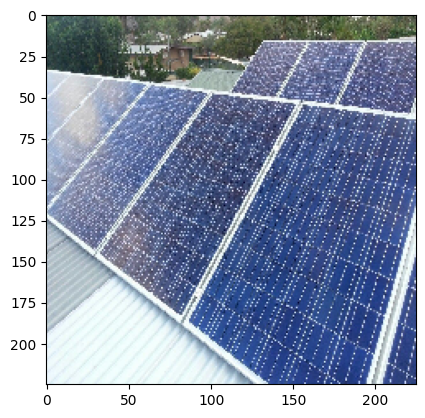

In [10]:
img_clean_1 = load_img(f"raw_data/training-data/clean/Cleaan (4).jpeg", target_size=(225, 225))
predictImage_binary(img_clean_1,model_clean_snow)
plt.imshow(img_clean_1);

1/1 [==============================] - 0s 40ms/step
Probabilities: 
[0.00079655]
1/1 [==============================] - 0s 38ms/step
Class :  clean
probability =  0.9992034518509172


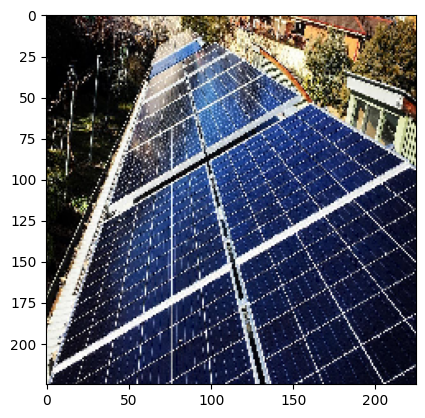

In [11]:
img_clean_2 = load_img(f"raw_data/training-data/clean/Cleaan (15).jpeg", target_size=(225, 225))
predictImage_binary(img_clean_2,model_clean_snow)
plt.imshow(img_clean_2);

1/1 [==============================] - 0s 39ms/step
Probabilities: 
[0.9521966]
1/1 [==============================] - 0s 39ms/step
Class :  snow
probability =  0.9521966


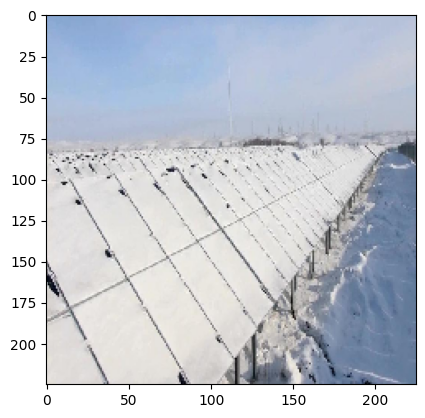

In [15]:
img_clean_2 = load_img(f"raw_data/training-data/solar/Solar (15).jpeg", target_size=(225, 225))
predictImage_binary(img_clean_2,model_clean_snow)
plt.imshow(img_clean_2);

1/1 [==============================] - 0s 46ms/step
Probabilities: 
[0.7565574]
1/1 [==============================] - 0s 24ms/step
Class :  snow
probability =  0.7565574


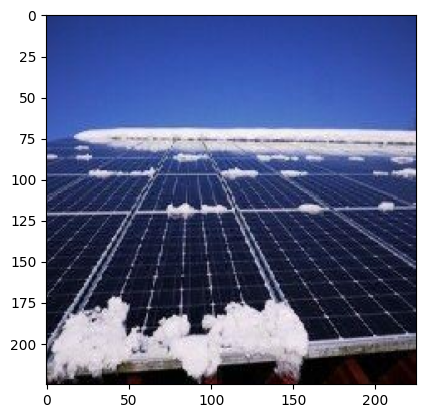

In [16]:
img_clean_2 = load_img(f"raw_data/training-data/solar/Solar (21).jpeg", target_size=(225, 225))
predictImage_binary(img_clean_2,model_clean_snow)
plt.imshow(img_clean_2);

1/1 [==============================] - 0s 38ms/step
Probabilities: 
[0.75577617]
1/1 [==============================] - 0s 43ms/step
Class :  snow
probability =  0.75577617


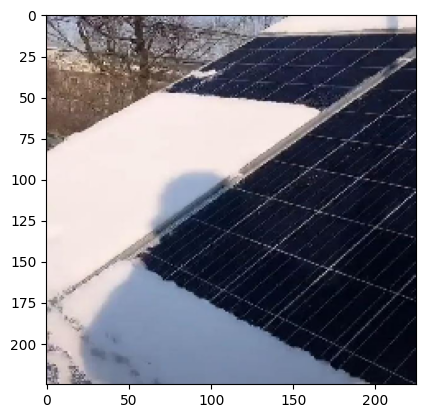

In [19]:
img_clean_2 = load_img(f"raw_data/training-data/solar/Solar (28).jpeg", target_size=(225, 225))
predictImage_binary(img_clean_2,model_clean_snow)
plt.imshow(img_clean_2);